In [227]:
import pandas as pd
import graphlab as gl
import numpy as np
from IPython.core.display import display
from scipy.spatial.distance import cosine,euclidean,pdist,squareform
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import entropy
from numpy.linalg import norm
from jenks import jenks
from itertools import chain,tee, izip
from urllib import unquote_plus
from titlecase import titlecase
from itertools import combinations
import itertools
import seaborn

In [228]:
# GLOBAL PARAMS
SESSION_THRESHOLD = 1800 # 30 minutes
MIN_LENGTH = 5 # Minimum number of scrobbles in a patch

In [229]:
### Load some example data
#fi = "../testData/mylistening.txt"
fi = "../testData/test_listening_data.tsv"
me = pd.read_table(fi,header=None,
            names=['user_id','item_id','artist_id','ts'],parse_dates=['ts']).sort_values(by='ts')
### Build artist_name:artist_idx dict from 
artist_idx = {}
for line in open('../GenreModeling/data/vocab_idx'):
    line = line.strip().split('\t')
    artist_idx[line[0]] = int(line[1])
### Load artist feature matrix
features = np.load('../GenreModeling/data/features/lda_artists/features_190.npy')

In [244]:
artist_idx[artist_ids.get(1)]

67

In [230]:
### Build artist_id:artist_name and artist_name:artist_idx dicts from database data
artist_ids = {}
artist_names = {}
for line in open('../GenreModeling/data/artist_ids'):
    line = line.strip().split('\t')
    artist_ids[int(line[0])] = line[1]
    artist_names[line[1]] = int(line[0])
    
# Lookup function to get features for a given artist ID or artist name
def get_features(aid=None,artist_name=None):
    if artist_name is None:
        artist_name = artist_ids.get(aid)
        if not artist_name: 
            return np.repeat(np.nan,features.shape[1])
    return features[artist_idx[artist_name]]

# Function for Jensen Shannon Distance (Sqrt of Jensen Shannon Divergence)
def JSD(P, Q):
    if np.all(np.isnan(P)) or np.all(np.isnan(Q)):
        return np.nan
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return np.sqrt(np.clip(0.5 * (entropy(_P, _M) + entropy(_Q, _M)),0,1))

# Function to calculate distance between any two artists 
def calc_sim(artist1,artist2,metric='cosine'):
    if np.isnan(artist1) or np.isnan(artist2):
        return np.nan
    if artist1==artist2:
        return 0.0
    features1 = get_features(artist1)
    if np.all(np.isnan(features1)): return np.nan
    features2 = get_features(artist2)
    if np.all(np.isnan(features2)): return np.nan
    if metric == 'JSD':
        return JSD(features1,features2)
    elif metric == 'cosine':
        return cosine(features1,features2)
    elif metric == 'euclidean':
        return euclidean(features1,features2)

# for proper formatting of artist names
def formatter(s):
    if s:
        try: return titlecase(unquote_plus(s))
        except: return s
    return 'UNKNOWN'

# Just a clean format for presenting example dataframes 
def pres_format(input_df):
    df = input_df.copy()
    df = df[['ts','artist_name','dist']].reset_index(drop=True)
    df.columns = ['timestamp','artist','distance']
    df['artist'] = df['artist'].apply(formatter)
#    df['previous artist'] = df['previous artist'].apply(formatter)
    return df

In [231]:
# All pre-formatting of data
new = me.copy()
new['before'] = new.shift(1)['artist_id']
new['td'] = new['ts']-new.shift(1)['ts']
new['td'] = new['td'].astype(int) / 10**9
new['artist_name'] = new.apply(lambda row: artist_ids.get(row['artist_id']),axis=1)
new['before_name'] = new.shift(1)['artist_name']
new = new[['ts','artist_id','before','td','artist_name','before_name']]
new['dist'] = new.apply(lambda row: calc_sim(row['artist_id'],row['before']),axis=1)
new['features'] = new['artist_name'].apply(lambda a: get_features(artist_name=a))
new = new.reset_index(drop=True)

In [232]:
### Add session index information
session_idx = 0
session_indices = []
for val in new['td']>=SESSION_THRESHOLD:
    if val:
        session_idx +=1
    session_indices.append(session_idx)
new['session'] = session_indices

### deletes session shorter than MIN_LENGTH
#session_counts = new['session'].value_counts()
#new = new[new['session'].isin(session_counts[session_counts>=MIN_LENGTH].index)]

In [233]:
### Get top artist info

top_artists = new['artist_id'].value_counts().reset_index()
top_artists.columns = ['artist_id','scrobbles']
top_artists['artist_name'] = top_artists['artist_id'].apply(lambda x: artist_ids.get(x))


In [234]:
### If we want to remove sessions with unknown artists (but let's not for now)
def remove_sessions_with_unknowns(df):
    if df['artist_name'].hasnans:
        return None
    else:
        return df
#new = new.groupby('session').apply(remove_sessions_with_unknowns).reset_index(drop=True)


In [235]:
### Add patch index information
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return izip(a, b)

s=20
dist_thresh = 0.2

def patch_segmenter(df,shuffle=True):
    l = df['artist_id']
    indices = list(np.array([len(list(v)) for g,v in itertools.groupby(l)][:-1]).cumsum())
    new_indices = []

    for b in indices:
        try:
            dist = cosine(df.iloc[b]['features'],df.iloc[b-1]['features'])
        except ValueError:
            dist = 1.
        #print b,test.iloc[b-1]['artist_name'],test.iloc[b]['artist_name'],dist
        if dist >= dist_thresh:
            new_indices.append(b)
    
    
    if new_indices:

        last_patch = False
        final_indices = []
        for i,(a,b) in enumerate(pairwise([0]+new_indices+[len(df)])):
            if b-a>=MIN_LENGTH:
                final_indices.append(a)
                last_patch = True
            else:
                if last_patch:
                    final_indices.append(a)
                last_patch = False
        
        return final_indices,new_indices
    return new_indices,new_indices
        
test = new.copy()
indices_shuffle = np.zeros(len(test),dtype=int)
indices_simple = np.zeros(len(test),dtype=int)
offset_shuffle = 0
idx_shuffle=0
offset_simple = 0
idx_simple=0

for session in test.groupby('session'):
    result_shuffle,result_simple = patch_segmenter(session[1])
    n=len(session[1])
    
    if len(result_shuffle)==0:
        indices_shuffle[offset_shuffle:offset_shuffle+n] = idx_shuffle
        idx_shuffle+=1
    else:
        indices_shuffle[offset_shuffle:offset_shuffle+result_shuffle[0]] = idx_shuffle
        idx_shuffle+=1
        for v, w in pairwise(result_shuffle):
            indices_shuffle[offset_shuffle+v:offset_shuffle+w] = idx_shuffle
            idx_shuffle+=1
        indices_shuffle[offset_shuffle+result_shuffle[-1]:offset_shuffle+result_shuffle[-1]+n] = idx_shuffle
        idx_shuffle+=1
    offset_shuffle += n

    if len(result_simple)==0:
        indices_simple[offset_simple:offset_simple+n] = idx_simple
        idx_simple+=1
    else:
        indices_simple[offset_simple:offset_simple+result_simple[0]] = idx_simple
        idx_simple+=1
        for v, w in pairwise(result_simple):
            indices_simple[offset_simple+v:offset_simple+w] = idx_simple
            idx_simple+=1
        indices_simple[offset_simple+result_simple[-1]:offset_simple+result_simple[-1]+n] = idx_simple
        idx_simple+=1
    offset_simple += n


    
if result_shuffle:
    indices_shuffle[offset_shuffle+result_shuffle[-1]:] = idx
else:
    indices_shuffle[offset_shuffle:] = idx
    
if result_simple:
    indices_simple[offset_simple+result_simple[-1]:] = idx
else:
    indices_simple[offset_simple:] = idx

test['patch_idx_shuffle'] = indices_shuffle
test['patch_idx_simple'] = indices_simple

In [236]:
# add artist block info
### https://stackoverflow.com/questions/14358567/finding-consecutive-segments-in-a-pandas-data-frame

test['block'] = (test['artist_id'].shift(1) != test['artist_id']).astype(int).cumsum()


In [237]:
test[test['session']==20]

,ts,artist_id,before,td,artist_name,before_name,dist,features,session,patch_idx_shuffle,patch_idx_simple,block
1086,2005-11-05 21:35:53,376,11810.0,2394.0,the+mars+volta,new+order,0.805956,"[5.32254464546e-06, 0.00297989085737, 9.176801...",20,33,978,1005
1087,2005-11-05 21:45:48,1362,376.0,595.0,bauhaus,the+mars+volta,0.957744,"[2.63131581579e-07, 4.92582320715e-05, 2.63131...",20,33,979,1006
1088,2005-11-05 21:49:30,12180,1362.0,222.0,danzig,bauhaus,0.825372,"[3.54257756668e-07, 0.000546903124745, 3.54257...",20,33,980,1007
1089,2005-11-05 21:53:21,1994,12180.0,231.0,the+white+stripes,danzig,0.841584,"[0.000130706414263, 0.000504450163439, 0.00015...",20,33,981,1008
1090,2005-11-05 21:57:02,749877,1994.0,221.0,None,the+white+stripes,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",20,33,982,1009
1091,2005-11-05 22:00:24,1994,749877.0,202.0,the+white+stripes,None,NaN,"[0.000130706414263, 0.000504450163439, 0.00015...",20,33,983,1010
1092,2005-11-05 22:04:25,21014,1994.0,241.0,brian+eno,the+white+stripes,0.885440,"[1.63918921112e-07, 9.50729742449e-06, 0.00590...",20,33,984,1011
1093,2005-11-05 22:08:57,502,21014.0,272.0,him,brian+eno,0.991304,"[2.16078255918e-06, 0.0082165844964, 3.1830687...",20,33,985,1012
1094,2005-11-05 22:14:39,41936,502.0,342.0,vhs+or+beta,him,0.976594,"[0.000737493305625, 0.00449835331712, 2.224044...",20,33,986,1013
1095,2005-11-05 22:20:11,17466028,41936.0,332.0,None,vhs+or+beta,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",20,33,987,1014


In [238]:
# patch summary data methods

def patch_stats(df,agg_stats=True):
    first = df.iloc[0]
    n = len(df)
    start = first['ts']
    if agg_stats:
        artists = df['artist_id'].values
        if (n==1) or (len(artists)==1):
            diversity = 0.
            centroid = first['features']
        else:
            #diversity = (len(df['artist_id'].unique())/float(len(df))) * df['dist'][1:].mean()
            features = np.array([get_features(i) for i in df['artist_id']])
            centroid = np.nanmean(features,axis=0)
            diversity = np.nanmean(pdist(features,metric='cosine'))
            #diversity = (((len(df['artist_id'].unique())-1)/float(len(df)-1)) + df['dist'][1:].mean())/2.
            #centroid = np.nanmean([get_features(i) for i in df['artist_id']],axis=0)
        
        return pd.Series({'diversity':diversity,'centroid':centroid,'start_ts':start,'n':n,'artists':artists})
    else:
        artist = first['artist_id']
        return pd.Series({'start_ts':start,'n':n,'artist':artist})
    

basis = 'patch_idx_shuffle'
if basis=='block': agg_stats=False
else: agg_stats = True
result = test.groupby(basis).apply(patch_stats,agg_stats)#.reset_index(level=1,drop=True)
result['start_idx'] = result['n'].cumsum().shift(1).fillna(0).astype(int)
    
result



,artists,centroid,diversity,n,start_ts,start_idx
patch_idx_shuffle,,,,,,
0,"[1180, 15892, 1172, 12278, 11810, 502, 376, 39...","[0.00202568344267, 0.00429799873555, 0.0009212...",8.029417e-01,52,2005-10-27 22:36:18,0
1,"[11810, 1362, 40085, 233, 6264, 8506, 7441, 11...","[0.000843418046397, 0.00371540947668, 0.005220...",8.199169e-01,10,2005-10-28 03:40:09,52
2,"[1081, 36393, 6686, 1362, 1180, 1972, 19069, 3...","[0.00246566861778, 0.0202175889391, 0.00336307...",8.125608e-01,23,2005-10-28 15:37:35,62
3,"[793877, 18773, 19069, 233, 9471, 3950, 8626, ...","[0.00022891018598, 0.0170397299573, 0.00247081...",7.910647e-01,15,2005-10-29 00:09:59,85
4,"[644, 370, 41936, 1165, 1934, 11810, 1081, 108...","[0.00123891270831, 0.0126498558096, 0.00066455...",8.081788e-01,56,2005-10-29 08:12:20,100
6,"[644, 644, 644, 644, 644, 644, 644]","[0.000872037758315, 0.102509447189, 4.49815413...",0.000000e+00,7,2005-10-29 16:49:26,156
7,"[2719, 2719, 2719, 2719, 2719, 2719, 2719, 2719]","[2.60820737057e-05, 0.00212012108184, 3.515104...",1.110223e-16,8,2005-10-29 17:28:57,163
8,"[121612, 63460, 749877, 749877, 63460, 40835, ...","[0.000672836118341, 0.00169326455237, 0.010440...",5.049815e-01,13,2005-10-29 18:20:06,171
9,"[3971, 3971, 3971, 3971, 35584, 21682, 21682, ...","[0.00123809332749, 0.000744589545705, 0.001059...",1.219721e-01,8,2005-10-29 19:19:35,184


In [239]:
### Session clustering


[0.0, 0.37371552, 0.97927511] [0.0, 0.2742911, 0.66957676, 0.97927511]


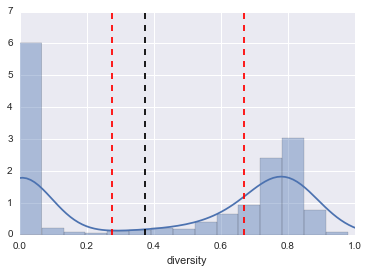

In [240]:
brks2 = jenks(result[result['n']>=5]['diversity'].dropna(),2)
brks3 = jenks(result[result['n']>=5]['diversity'].dropna(),3)
print brks2,brks3
#ax = seaborn.distplot(result[result['n']>=5]['diversity'].dropna(),norm_hist=False)
ax = seaborn.distplot(result[(result['n']>=5)&(result['diversity']>0)]['diversity'].dropna(),bins=15)
ax.axvline(brks2[1],c='k',ls='--')
ax.axvline(brks3[1],c='r',ls='--')
ax.axvline(brks3[2],c='r',ls='--')
#ax.axvline(brks[2],c='k',ls='--')
#ax.set_yscale('log')
ax.set_xlim(0,1);


In [258]:
indices = {}
for k in artist_ids:
    indices[k] = artist_idx[artist_ids[k]]
    
